In [1]:
%%capture capt
import numpy as np
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import multiprocessing
from multiprocessing import Pool
import pickle

### Dictionnaires de GridSearch pour les meilleurs paramètres de chaque fonction

In [2]:
with open('../data/grid_search/gridSearch.pickle', 'rb') as handle:
    grid_search = pickle.load(handle)
print(len(grid_search))

4199


In [3]:
with open('../data/grid_search/gridSearch_norm.pickle', 'rb') as handle:
    grid_search_norm = pickle.load(handle)
print(len(grid_search_norm))

4226


In [4]:
with open('../data/grid_search/gridSearch_scaled.pickle', 'rb') as handle:
    grid_search_scaled = pickle.load(handle)
print(len(grid_search_scaled))

19


In [5]:
def get_nb_clusters_from_key(key):
    return int(key.split(',')[0].split(':')[-1])

def get_meilleurs_params(dic, max_clusters=None):
    max_score = -float('inf')
    max_key = ''
    if not max_clusters:
        max_clusters = float('inf')
        
    for key in dic.keys():
        if dic[key] >= max_score and get_nb_clusters_from_key(key) <= max_clusters:
            max_score, max_key = dic[key], key
    return max_score, max_key

In [6]:
best_params_norm = get_meilleurs_params(grid_search_norm)
print(f"Meilleurs params normalise --> {best_params_norm}")

Meilleurs params normalise --> (0.058388449763529505, 'n_clusters:33, weights:50 5 1')


In [7]:
best_params = get_meilleurs_params(grid_search)
print(f"Meilleurs params non normalise --> {best_params}")

Meilleurs params non normalise --> (0.05881224330601615, 'n_clusters:5, weights:50 50 5')


In [8]:
best_params_scaled = get_meilleurs_params(grid_search_scaled)
print(f"Meilleurs params scaled --> {best_params_scaled}")

Meilleurs params scaled --> (0.5561912100309752, 'n_clusters:5, weights:1 1 1')


In [9]:
def score_fct_clusters(dic, title):
    range_max_clusters = range(5, 42)
    best_params_scaled = [get_meilleurs_params(dic, max_clusters=max_clusters)[0] for max_clusters in range_max_clusters]
    plt.plot(range_max_clusters, best_params_scaled)
    plt.title(f"Max score clusters en fonction du nombre max de clusters autorisés\n{title}")
    plt.xlabel("Nb clusters max autorisé")
    plt.show()

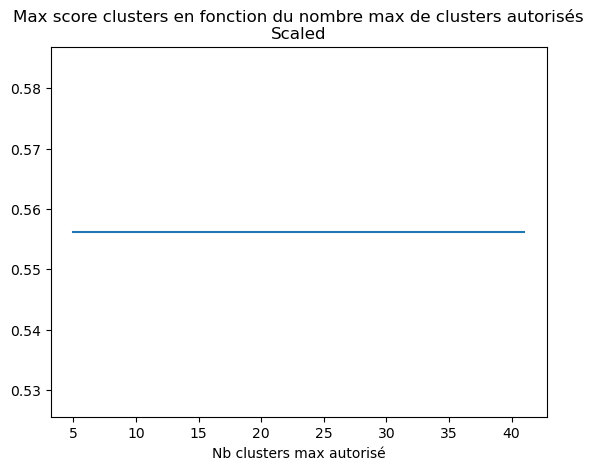

In [10]:
score_fct_clusters(grid_search_scaled, 'Scaled')

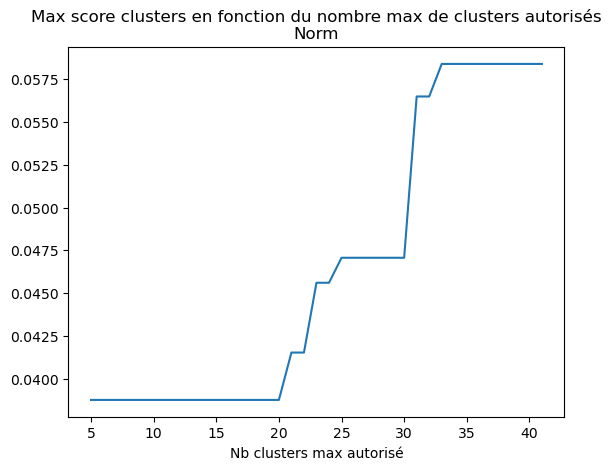

In [11]:
score_fct_clusters(grid_search_norm, 'Norm')

### Clustering pour chacun des meilleurs params

In [12]:
%run Calculate_clusters.ipynb

Installation/Importation des librairies necessaires.
CPU cores available -> 56


In [13]:
def get_weights_from_params(params):
    key = params[1].split(',')[-1].split(':')[-1].split(' ')
    weights_params = [int(weight) for weight in key]
    return weights_params

In [14]:
import warnings
warnings.filterwarnings("ignore")

#### Custom scaled

In [15]:
max_clusters = 15
best_params_scaled_max_clusters = get_meilleurs_params(grid_search_scaled, max_clusters=max_clusters)
print(best_params_scaled_max_clusters)

(0.5561912100309752, 'n_clusters:5, weights:1 1 1')


In [16]:
kmedoids_scaled_max_clusters, base_scaled_max_clusters = base_finale(X_patient, 'custom', scaled=True, 
                                                 weights_metric=get_weights_from_params(best_params_scaled_max_clusters), 
                                                 n_clusters = get_nb_clusters_from_key(best_params_scaled_max_clusters[-1]))

Calcul des distances, weights=[1, 1, 1]
Distances calculees en 227s, calcul des clusters -> n_clusters=5


In [17]:
for i in range(1, 1+get_nb_clusters_from_key(best_params_scaled_max_clusters[-1])):
    print(base_scaled_max_clusters[f'cluster{i}'].sum())

7988
1
374
1
1687


In [34]:
base_scaled_max_clusters.to_csv('../data/grid_search/scaled_15.csv', index=False)
medoid_indices = kmedoids_scaled_max_clusters.medoid_indices_
with open('../data/grid_search/scaled_15_medoids.npy', 'wb') as f:
    np.save(f, medoid_indices)

#### Custom norm

In [34]:
max_clusters = 25

In [35]:
best_params_norm = get_meilleurs_params(grid_search_norm, 25)
print(best_params_norm)

(0.04706458274730053, 'n_clusters:25, weights:50 5 1')


In [36]:
kmedoids_norm, base_norm = base_finale(X_patient, 'custom_norm', scaled=False, 
                                       weights_metric=get_weights_from_params(best_params_norm), 
                                       n_clusters = get_nb_clusters_from_key(best_params_norm[-1]))

ValueError: too many values to unpack (expected 2)

In [ ]:
base_norm.to_csv('../data/grid_search/norm_25.csv', index=False)
medoid_indices = kmedoids_norm.medoid_indices_
with open('../data/grid_search/norm_medoids_25.npy', 'wb') as f:
    np.save(f, medoid_indices)

#### Custom

In [13]:
best_params = get_meilleurs_params(grid_search)
print(best_params)

(0.05881224330601615, 'n_clusters:5, weights:50 50 5')


In [19]:
kmedoids_std, base_std = base_finale(X_patient, 'custom', scaled=False, 
                                     weights_metric=get_weights_from_params(best_params), 
                                     n_clusters = get_nb_clusters_from_key(best_params[-1]))